# K Nearest Neighbor Clustering to Identify Developing Neighborhoods in Baltimore, MD
### Andrew Timmons
###### Coursera Data Science Capstone Project

#### Introduction

Few American cities exemplify the pervasive issue of 'urban blight' to the extent of Baltimore City, Maryland.  Located in the notorious 'Rust Belt,' Baltimore has experienced substantial economic and population collapse in the past 50 years.  Plagued by contractions in the American steel industry, since 1970 the population of Baltimore City has declined by >30% (U.S. Census).  Concaminant with this rapid economic and demographic decline, the crime rate in Baltimore City has skyrocketed, giving Baltimore the dubious distinction of one of the most violent cities in the US.  

Vast financial and social resources have been deployed the revitalize some of Baltimore's most destitute neighborhoods. As a result of public and private investments, certain neighborhoods have begun experiencing a revitalization of neighborhood character and local business.  Early investment in a gentrifying neighborhood is a potentially lucrative opportunity, particularly for young professionals purchasing a first home.  Fortunately, with the variety of data available from the Baltimore City government, the US census, and the FourSquare venue database, we can identify candidates for gentrification using quantitative, machine-learning approaches. 

#### Approach

Using K Nearest Neighbor clustering approaches, I will identify neighborhoods with low median property values in Baltimore that show similarity to more expensive neighborhoods.  Clustring will take into account a variety of different venues as taken from FourSquare and various demographic statistics provided by the Baltimore City Government. 

_Data Set 1: Baltimore Demographics_
The United States census provides neighborhood-level statistics on total populations across the United States.  I will source this data from the United States census bureau for each neighborhood within Baltimore city. I will directly import this data into a dataframe from a local file to avoid navigating an API call to a 3rd party dataset. All data files used will be stored in my github repository.

_Data Set 2: Baltimore Crime Rates_
The Baltimore City police department provides a list of crime statistics.  Using this dataset, I will quantify the number of violent crimes occuring in each neighborhood.  

_Data Set 3: Venues in Baltimore City_
Using the FourSquare dataset, I will quantify the number of different venues occuring in each neighborhood.  Using these venues, I will use KNN algorithms to cluster neighborhoods in Baltimore city.

#### Readout

I am primarily interested in the clusters that contain expensive Baltimore neighborhoods.  Within clusters of expensive neighborhoods, I will identify those neighborhoods that have the cheapest property values.  As these cheaper neighborhoods are quantitatively  similar to more expensive neighborhoods, these neighborhoods represent reasonable investment opportunities

## Contents:
* [Part 1 - Loading and Preparing Datasets for Analysis](#first-bullet)
* [Part 2 - Initial Analysis of Datasets](#second-bullet)
* [Part 3 - Obtaining venue data ](#third-bullet)
* [Part 4 - K Nearest Neighbor Clustering of Neighborhoods](#fourth-bullet)
* [Part 5 - Making Inferences from Clusters](#fifth-bullet)
* [Part 6 - Conclusions](#sixth-bullet)

### Part 1 - Loading and Preparing Datasets for Analysis <a class="anchor" id="first-bullet"></a>

Census data and crime data were taken from the Maryland Census Bureau and the Baltimore Police Department, respecivelly.  To avoid issues with database format or API changes, datasets were downloaded as CSV files and uploaded to a github repository.  This notebook links to the csv files on the github repository for stability.

_Data Sources_

- Neighborhood level census data was sourced from the 2010 United States Census and compiled by ARCGIS.  Data can be accessed here https://vital-signs-bniajfi.hub.arcgis.com/datasets/56d5b4e5480049e98315c2732aa48437_0/data 

- Median household income data was sourced from the 2010 United States Census and compiled by ARCGIS.  Data can be accessed here https://vital-signs-bniajfi.hub.arcgis.com/datasets/8613366cfbc7447a9efd9123604c65c1_0/data

- Crime data is compiled by the Baltimore city police department and made available thorugh an OpenData program.  Data are also accessible through ARCGIS and can be found here https://vital-signs-bniajfi.hub.arcgis.com/datasets/ab03385abf3b4f50aec0b090caa8877a_0/data

- Venue data was sourced from FourSquare.  The code for this API call is stored in this notebook.  To avoid making repeated calls to the FourSquare API as I worked on this project, the resulting venue data was Pickled and stored in Github.  

In [1]:
#Import Dependencies
import pandas as pd
import numpy as np

In [57]:
#Read CSVs from datasets stored in my GitHub Repo
census_data = pd.read_csv(r'https://raw.githubusercontent.com/Andrewt527/Coursera_Capstone/master/Baltimore%20Neighborhood%20Populations.csv')
crime_data = pd.read_csv(r'https://raw.githubusercontent.com/Andrewt527/Coursera_Capstone/master/Crimes%20per%201000.csv')
income_data = pd.read_csv(r'https://raw.githubusercontent.com/Andrewt527/Coursera_Capstone/master/Median%20Household%20Income.csv')
homeprice_data = pd.read_csv(r'https://raw.githubusercontent.com/Andrewt527/Coursera_Capstone/master/Median%20Price.csv')

In [76]:
#Print Info about each dataset
print('We are analyzing census data from', census_data.shape[0], 'neighborhoods in Baltimore')
print('We are analyzing crime data from', crime_data.shape[0], 'neighborhoods in Baltimore')
print('We are analyzing income data from', income_data.shape[0], 'neighborhoods in Baltimore')
print('We are analyzing home price data from', homeprice_data.shape[0], 'neighborhoods in Baltimore')
print('We are observing a total population of', census_data['Population'].sum(), 'people')

We are analyzing census data from 55 neighborhoods in Baltimore
We are analyzing crime data from 55 neighborhoods in Baltimore
We are analyzing income data from 55 neighborhoods in Baltimore
We are analyzing home price data from 55 neighborhoods in Baltimore
We are observing a total population of 615724 people


In [355]:
#Grab relevant columns from each dataset, and then re-name columns to be more descriptive 
populations = census_data

crimes = crime_data[["CSA2010", "viol18"]]
crimes.columns = ['Neighborhood','Crimes per 1000 People 2018']

incomes = income_data[["CSA2010", "mhhi18"]]
incomes.columns = ['Neighborhood','Median Income in 2018']

homesales = homeprice_data[["CSA2010", "salepr18"]]
homesales.columns = ['Neighborhood','Median Home Price in 2018']

In [356]:
#Merge the datasets
from functools import reduce
dfs = [populations,crimes,incomes,homesales]

neighborhood_data = reduce(lambda left, right: pd.merge(left, right, on=['Neighborhood'], how='inner'), dfs)
print('We have compiled data from', neighborhood_data.shape[0], 'neighborhoods in Baltimore')
neighborhood_data.head()

We have compiled data from 55 neighborhoods in Baltimore


,Neighborhood,Population,Crimes per 1000 People 2018,Median Income in 2018,Median Home Price in 2018
0,Allendale/Irvington/S. Hilton,16217,20.657335,38535.562176,75000.0
1,Beechfield/Ten Hills/West Hills,12264,12.312459,58055.306613,159450.0
2,Belair-Edison,17416,15.215893,42633.619512,79900.0
3,Brooklyn/Curtis Bay/Hawkins Point,14243,24.362845,39936.512500,67500.0
4,Canton,8100,9.135802,116911.088235,295500.0


### Part 2 - Initial Analysis of Datasets <a class="anchor" id="second-bullet"></a>

An easy initial analysis is to determine whether there are correlations between a neighborhood's population, median incomes, and crime rates.  This will provide an initial assessment of the factors we have chosen to analyze

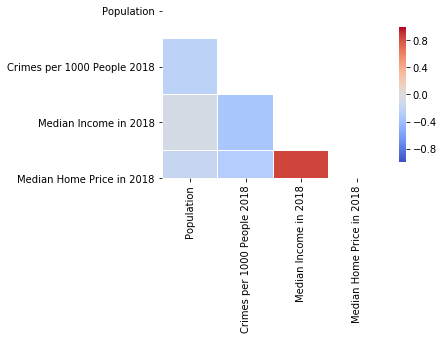

In [358]:
#Lets initially inspect the correlations between demographic indicators and venues 
import matplotlib.pyplot as plt
%matplotlib inline

# Compute the correlation matrix
corr = neighborhood_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = 'coolwarm'

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Unsurprisingly, we observe a strong positive correlationb between the median income of each neighborhood and the median home prices in those neighborhoods.  In addition, we observe that the number of violent crimes per 1000 residents is negatively correlated with median income, meaning that wealthier neighborhoods generally have less crime than poorer neighborhoods. 

In addition to the income of neighborhood residents, wealthy and poorer neighborhoods may  differ substantially in the breadth of services that are offered to neighborhood residents.  In the context of identifying developing neighborhoods, it would be valuable to identify lower-cost neighborhoods with distributions of venues similar to those in more expensive neighborhoods. To address this question, we will use the FourSquare API to query the abundance of specific venues in Baltimore neighborhoods 

### Part 3 - Obtaining venue data <a class="anchor" id="third-bullet"></a>

##### Part 3.1 - Obtaining Coordinates for Baltimore Neighborhoods

In [92]:
# Import Dependencies
import requests # library to handle requests
import random # library for random number generation
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
import folium # plotting library

Before using the FourSquare API, we need to identify the latitude and longitude coordinates that represent each neighborhood. 

In [94]:
neigh = list(neighborhood_data['Neighborhood'])

In [96]:
#We need to clean up the neighborhood names before using them in the geolocator 

#Iteratively remove combined names (i.e Allendale/Irvington/S. Hilton -----> Allendale)
neigh = list(i.split('/', 1)[-1] for i in neigh)
neigh = list(i.split('/', 1)[0] for i in neigh)
neigh = list(i.split('/', 1)[0] for i in neigh)

#Remove hyphens from name
neigh = list(i.split('-', 1)[-1] for i in neigh)

#Remove 'greater' designations from name
neigh = list(i.split('Greater ', 1)[-1] for i in neigh)

#Remove 'the' designations from name
neigh = list(i.split('The ', 1)[-1] for i in neigh)

#Remove 'baltimore' from end of name
neigh = list(i.split(' Baltimore', 1)[0] for i in neigh)

#'Waverlies' is not recognized by the geocoder; change this to 'Waverly'
["Waverly" if x=="Waverlies" else x for x in neigh]

print(len(neigh))

55


In [97]:
#Pass each neighborhood to a geolocator, which will provide a latitude and longitude for the center of that neighborhood
latlong = []
geolocator = Nominatim(user_agent="at-coursera")
for i in neigh:
    location = geolocator.geocode(i + ", Baltimore")
    if location is None:
        locs = [0,0]
    else:
        locs = [location.raw['lat'],location.raw['lon']]
    latlong.append(locs)

latlong = pd.DataFrame(latlong)

In [98]:
#Add these locations to the neighborhood_data dataframe
neighborhood_data["Latitude"] = latlong[0]
neighborhood_data["Longitude"] = latlong[1]

#Remove neighborhoods that do not contain lat/long data
neighborhood_data = neighborhood_data[neighborhood_data.Latitude != 0]
neighborhood_data = neighborhood_data[neighborhood_data.Longitude != 0]

#Fix the index so that there are no skipped values that will interfere with subsequent `for` loops
neighborhood_data.index = range(len(neighborhood_data['Neighborhood']))

In [99]:
print('We have location data for', neighborhood_data.shape[0], 'neighborhoods in Baltimore')
print(55- neighborhood_data.shape[0], 'neighborhood(s) did not have location data')

We have location data for 54 neighborhoods in Baltimore
1 neighborhood(s) did not have location data


##### Part 3.2 - Obtaining Venue Data for Each Neighborhood

In [101]:
# Define FourSquare Client ID and Client Secret.  These fields are removed from my final project.  
# The code for the API call is included, but after making the initial call, I pickled the resulting data locally.
# This is to avoid making repeated calls to the FourSquare database when constructing the
# rest of this notebook.

CLIENT_ID = 'ARCEIKHAZZSD2Q0QXSGAVNVPWYF4RIMQJIU4JQILJYBCXPZQ' # your Foursquare ID
CLIENT_SECRET = 'KYAUXR43X2CZGSKC2103ZOXXBFAXSWPSFRVOBBD14PHXEKZP' # your Foursquare Secret
VERSION = '20180604'
RADIUS = 800 #roughly 10 city blocks
LIMIT = 200 

In [167]:
# URL Constructor.  We will use this feature to fetch specific venues
url_list = []
categoryId = '52e81612bcbc57f1066b79f1' #Bistro

#'4bf58dd8d48988d110941735' #Italian Restaurant
#'4bf58dd8d48988d1fa931735' #Hotel
#'4bf58dd8d48988d12f941735' #Library
#'4bf58dd8d48988d118951735' #Grocery Store
#'4bf58dd8d48988d1e0931735' #Coffee Shop
#'4d4b7105d754a06378d81259' #shop or service
#'4bf58dd8d48988d13b941735' #school
#'4d4b7105d754a06374d81259' #general food
#'4d954b0ea243a5684a65b473' #convenience store
#'4bf58dd8d48988d186941735' #liquor store

for i in range(len(neighborhood_data['Latitude'])):
    latitude = neighborhood_data['Latitude'][i]
    longitude = neighborhood_data['Longitude'][i]
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, RADIUS, LIMIT, categoryId)
    url_list.append(url)


In [168]:
#Function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#Define an empty list, into which we will pass dataframes extracted from the FourSquare JSON files
df_list = []

#Iterate over the list of urls generated for each neighborhood.  Extract venue data from each JSON file into a 
#dataframe, and pass that dataframe to the df_list

for i in range(len(url_list)):
    results = requests.get(url_list[i]).json()
    #venue_list.append(results)
    items = results['response']['groups'][0]['items']
    if len(items) == 0:
        dataframe_filtered = ["No venues in range"]
        df_list.append(dataframe_filtered)
        continue
    else:
        dataframe = json_normalize(items)
        filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
        dataframe_filtered = dataframe.loc[:, filtered_columns]
        dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)
        dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]
        df_list.append(dataframe_filtered)

In [169]:
#Save to pkl file so that we don't have to make redundant API calls
import pickle
with open(r'C:\Users\Andrew.Timmons\Desktop\Snapgene Collections\Coding\Notebooks\Venue pkls\bistro_list_800m.pkl', 'wb') as f:
    pickle.dump(df_list, f)

In [170]:
#Load data from pkl files
import pickle
with open(r'C:\Users\Andrew.Timmons\Desktop\Snapgene Collections\Coding\Notebooks\Venue pkls\liquorstore_list_800m.pkl', 'rb') as f:
    liquor_stores = pickle.load(f)

with open(r'C:\Users\Andrew.Timmons\Desktop\Snapgene Collections\Coding\Notebooks\Venue pkls\grocerystore_list_800m.pkl', 'rb') as f:
    grocerystore = pickle.load(f)

with open(r'C:\Users\Andrew.Timmons\Desktop\Snapgene Collections\Coding\Notebooks\Venue pkls\schools_list_800m.pkl', 'rb') as f:
    schools = pickle.load(f)
       
with open(r'C:\Users\Andrew.Timmons\Desktop\Snapgene Collections\Coding\Notebooks\Venue pkls\coffeeshop_list_800m.pkl', 'rb') as f:
    coffeeshops = pickle.load(f)

with open(r'C:\Users\Andrew.Timmons\Desktop\Snapgene Collections\Coding\Notebooks\Venue pkls\library_list_800m.pkl', 'rb') as f:
    library = pickle.load(f)

with open(r'C:\Users\Andrew.Timmons\Desktop\Snapgene Collections\Coding\Notebooks\Venue pkls\hotel_list_800m.pkl', 'rb') as f:
    hotels = pickle.load(f)   
    
with open(r'C:\Users\Andrew.Timmons\Desktop\Snapgene Collections\Coding\Notebooks\Venue pkls\italianrest_list_800m.pkl', 'rb') as f:
    italian = pickle.load(f)  
    
with open(r'C:\Users\Andrew.Timmons\Desktop\Snapgene Collections\Coding\Notebooks\Venue pkls\bistro_list_800m.pkl', 'rb') as f:
    bistros = pickle.load(f) 

In [106]:
#Our venue data is currently stored in lists of dataframes, as shown below.  We must define a function to get the total
#number of venues from each neighborhood
liquor_stores[3] #I.e. list all liquor stores in neighborhood index 3 (Curtis Bay)

,name,categories,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id
0,One Stop,Liquor Store,39.226136,-76.58934,"[{'label': 'display', 'lat': 39.226135970824, ...",39,21226,US,Curtis Bay,MD,United States,"[Curtis Bay, MD 21226, United States]",4c750feed8948cfa928a66da


In [107]:
def venue_number(venuelist):
    totalvenues = []
    for i in venuelist:
        length = len(i)
        totalvenues.append(length)
    return totalvenues

In [171]:
neighborhood_data['liquor stores'] = venue_number(liquor_stores)
neighborhood_data['grocery stores'] = venue_number(grocerystore)
neighborhood_data['schools'] = venue_number(schools)
neighborhood_data['coffee shops'] = venue_number(coffeeshops)
neighborhood_data['libraries'] = venue_number(library)
neighborhood_data['hotels'] = venue_number(hotels)
neighborhood_data['italian'] = venue_number(italian)
neighborhood_data['bistros'] = venue_number(bistros)

In [172]:
neighborhood_data.head()

,Neighborhood,Population,Crimes per 1000 People 2018,Median Income in 2018,Median Home Price in 2018,Latitude,Longitude,liquor stores,schools,coffee shops,grocery stores,libraries,hotels,italian,bistros
0,Allendale/Irvington/S. Hilton,16217,20.657335,38535.562176,75000.0,39.2816626,-76.6840405,1,1,1,1,1,1,1,1
1,Beechfield/Ten Hills/West Hills,12264,12.312459,58055.306613,159450.0,39.2878195,-76.7003502,1,2,1,1,1,1,1,1
2,Belair-Edison,17416,15.215893,42633.619512,79900.0,39.2908816,-76.610759,3,7,37,4,5,37,5,8
3,Brooklyn/Curtis Bay/Hawkins Point,14243,24.362845,39936.512500,67500.0,39.2257902,-76.5892145,1,3,2,1,1,1,1,1
4,Canton,8100,9.135802,116911.088235,295500.0,39.2816434,-76.5730592,4,7,5,2,4,1,3,2


### Part 4 - K Nearest Neighbor Clustering of Neighborhoods <a class="anchor" id="fourth-bullet"></a>

##### Part 4.1 - Assessing general correlations

Now that we have a collection of venue data for each neighborhood, we can start by observing correlations between venue distribution and neighborhood demographic and crime statistics 

In [176]:
#Define columns to drop from our neighborhood_data dataframe
dropcols = ['Neighborhood','Population','Latitude','Longitude']
neighborhood_corr = neighborhood_data.drop(dropcols, axis=1)

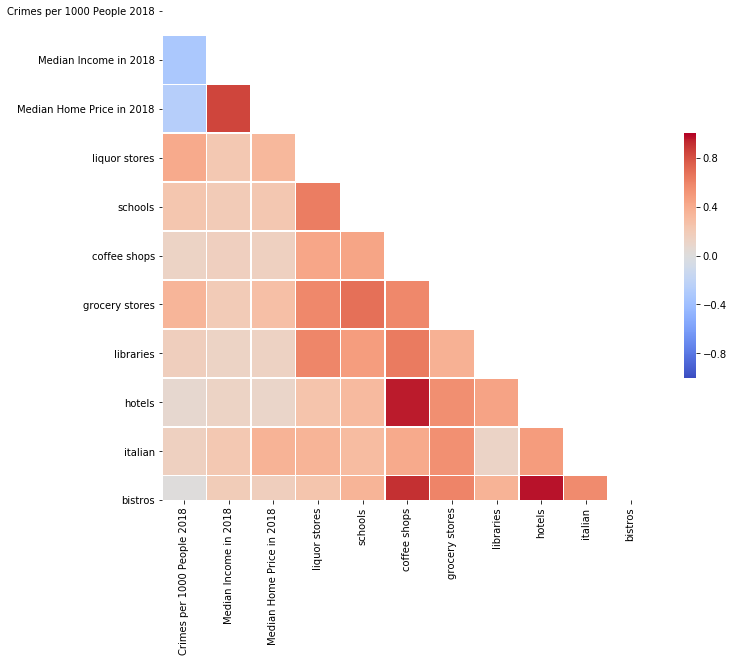

In [182]:
#Lets initially inspect the correlations between demographic indicators and venues 
import matplotlib.pyplot as plt
%matplotlib inline

# Compute the correlation matrix
corr = neighborhood_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = 'coolwarm'

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

There appear to be correlations between modest correlations between specific venues and the median home prices in a neighborhood.  Using clustering approaches, lets see if we can identify low-priced neighborhoods that are similar in venue composition to higher-priced neighborhoods

##### Part 4.2 - Building the Clustering Algorithm

In [295]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#Fetch x data and convert to numpy arrays
x_data = neighborhood_corr.drop('Median Home Price in 2018',axis=1).values

#Normalize our x data
x_norm = preprocessing.StandardScaler().fit(x_data).transform(x_data.astype(float))

In [296]:
#Categorize median home values into discrete classes.  I will divide neighborhoods
#into categories 1-5, where bin 5 is the highest 1/5 of home values
bins = 5
y_data = neighborhood_corr['Median Home Price in 2018']
y_data = np.array(pd.cut(y_data, bins=bins, labels=np.arange(bins), right=False))

In [297]:
#Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split (x_data, y_data, test_size = 0.2, random_state = 4)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (43, 10) (43,)
Test set: (11, 10) (11,)


In [298]:
#Train the model with different K values.

ks_tested = 11
mean_accuracy = np.zeros((ks_tested-1))
std_accuracy = np.zeros((ks_tested-1))

for k in range(1,ks_tested):
    #Train Model   
    knn = KNeighborsClassifier(n_neighbors = k).fit(x_train,y_train)
    #Predict labels of test set
    yhat=knn.predict(x_test)
    mean_accuracy[k-1] = metrics.accuracy_score(y_test, yhat)
    std_accuracy[k-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

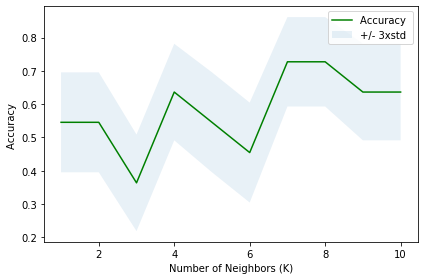

The best accuracy was with 0.7272727272727273 with k= 7


In [299]:
#Assess accuracy with different K values

plt.plot(range(1,ks_tested),mean_accuracy,'g')
plt.fill_between(range(1,ks_tested),mean_accuracy - 1 * std_accuracy,mean_accuracy + 1 * std_accuracy, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_accuracy.max(), "with k=", mean_accuracy.argmax()+1)

It seems that our model is accurately classifying neighborhoods in our test set.  We will next use this clustering algorithm to cluster our entire dataset, and then we will draw inferences from these clusters

##### Part 4.3 - Applying the clustering algorithm to our whole dataset

In [300]:
#Build the knn algorithm with a k=7
knn_opt = KNeighborsClassifier(n_neighbors = 7).fit(x_train,y_train)
yhat_all=knn_opt.predict(x_data)

In [301]:
#Place these clusters in the neighborhood_data dataframe
neighborhood_data['cluster'] = yhat_all

In [320]:
#Split the neighborhood_data dataset into dataframes of different clusters
clusters = dict(iter(neighborhood_data.groupby('cluster')))

In [332]:
#Define new dataframes based on clusters
cluster_a = clusters[0]
cluster_b = clusters[1]
cluster_c = clusters[3]



'39.2816626'

### Part 5 - Making Inferences from Clusters <a class="anchor" id="fifth-bullet"></a>

In [352]:
#Lets look at the clusters superimposed onto a map of Baltimore
import folium
neigh_map = folium.Map(location=[39.2904, -76.6122], zoom_start=11)

#Add Cluster 1 Labels
for i in range(len(cluster_a)):
    lat = cluster_a['Latitude'].iloc[i]
    lon = cluster_a['Longitude'].iloc[i]
    folium.CircleMarker([lat,lon],
                         radius = 3,
                         fill = True,
                         color = 'blue').add_to(neigh_map)

#Add Cluster 2 Labels
for i in range(len(cluster_b)):
    lat = cluster_b['Latitude'].iloc[i]
    lon = cluster_b['Longitude'].iloc[i]
    folium.CircleMarker([lat,lon],
                         radius = 3,
                         fill = True,
                         color = 'red').add_to(neigh_map)
    
#Add Cluster 3 Labels
for i in range(len(cluster_c)):
    lat = cluster_c['Latitude'].iloc[i]
    lon = cluster_c['Longitude'].iloc[i]
    folium.CircleMarker([lat,lon],
                         radius = 3,
                         fill = True,
                         color = 'green').add_to(neigh_map)
    
neigh_map

Interestingly, clusters of different neighborhoods appear to be distributed throughout Baltimore.  Many of the cluster 3 neighborhoods are centered around the inner harbor, which is a well-known developing area in Baltimore due to private investment.

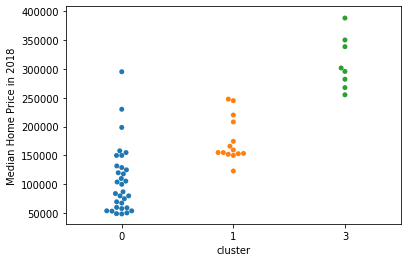

In [317]:
#Lets observe housing costs in different clusters
a_price = pd.DataFrame(cluster_a['Median Home Price in 2018'])
a_price['cluster'] = cluster_a['cluster']

b_price = pd.DataFrame(cluster_b['Median Home Price in 2018'])
b_price['cluster'] = cluster_b['cluster']

c_price = pd.DataFrame(cluster_c['Median Home Price in 2018'])
c_price['cluster'] = cluster_c['cluster']

alldata = pd.concat([a_price, b_price, c_price])

sns.swarmplot(x="cluster", y="Median Home Price in 2018", data=alldata)

The clusters appear to nicely separate median home prices into low/medium/high prices.  The cluster with the lowest incomes (cluster 0) appears to have many neighborhoods with very low home prices, and is skewed towards lower home prices. 

In contrast, cluster 1 and cluster 2 have a distribution of home prices more centered around an average.  Regarding the most attractive neighborhoods in which to purchase property, I believe that the cheapter neighborhoods in cluster 3 represent the most attractive neighborhoods for investment

In [319]:
#Sort cluster 3 by median home price
cluster_c_neighborhoods = cluster_c.sort_values(by='Median Home Price in 2018')
cluster_c_neighborhoods

,Neighborhood,Population,Crimes per 1000 People 2018,Median Income in 2018,Median Home Price in 2018,Latitude,Longitude,liquor stores,schools,coffee shops,grocery stores,libraries,hotels,italian,bistros,cluster
37,Mount Washington/Coldspring,5168,5.224458,84848.090909,255000.0,39.3362694,-76.6723867,3,6,1,3,1,1,1,1,3
15,Fells Point,9039,19.028654,98981.910064,267500.0,39.28219,-76.5946085,3,6,13,5,1,20,20,6,3
27,Highlandtown,7250,31.034483,88324.005277,282000.0,39.2884629,-76.5675452,4,7,4,4,1,1,2,1,3
4,Canton,8100,9.135802,116911.088235,295500.0,39.2816434,-76.5730592,4,7,5,2,4,1,3,2,3
29,Inner Harbor/Federal Hill,12855,14.080124,100932.230594,301500.0,39.2791922,-76.6106687,5,7,15,3,1,11,6,5,3
38,North Baltimore/Guilford/Homeland,17464,4.466331,98094.852941,338350.0,39.3395637,-76.6144428,2,5,2,1,1,1,1,1,3
47,South Baltimore,6406,4.995317,114107.319502,350000.0,39.2908816,-76.610759,3,7,37,4,5,37,5,8,3
21,Greater Roland Park/Poplar Hill,7377,2.575573,117951.409574,388000.0,39.3675693,-76.6393266,1,4,1,1,2,1,1,1,3


### Conclusions <a class="anchor" id="sixth-bullet"></a>

From this data, I would assume that the Mount Washington, Fells Point, and Highlandtown areas are the most attractive neighborhoods in which to purchase a house.  Visually inspecting this cluster reveals that, despite having substantially lower home prices, the Mount Washington, Fells Point, and Highlandtown areas share low crime rates and have similar venue distributions to the more expensive neighborhoods of South Baltimore and Roland Park.